# muensterTPC MC - Example Analysis

Lutz Althüser (<a href="mailto:l.althueser@uni-muenster.de">l.althueser@uni-muenster.de</a>)  
**Updated:** 2017-09-16

<h2 id="tocheading">Table of Content</h2>
<div id="tocinline"></div>

In [1]:
# Initialize notebook
%run "./00_Init.ipynb"

Init_Init("01_MC")
Init_cssNbWidth(80)
Init_cssNbCenterPlots()
Init_plt_LaTeXstyle()
Init_HTML_additions(attribution='LA')

In [ ]:
Init_saveHTML(Nb_name)

## The muensterTPC Geant4 Monte Carlo

...

## What is analyzed?

### Light Collection Efficiency
The absolute LCE can be obtained from the MC in the following way (where (x,y,z) is the corresponding Bin):   

$\text{LCE(x,y,z)} = \frac{N_{detected}(x,y,z) \cdot \text{QE} \cdot \text{CE} \cdot \text{QE_increase}}{N_{generated}(x,y,z)}$   

$N_{detected}(x,y,z)$: The number of photons generated at (x,y,z) and hitting a PMT photocathode (are registered by the PMTHitCollection) corrected by the PMT QE and CE (90%).  
$\text{QE}$: Quantum Efficiency which has to be applied per-PMT.  
$\text{CE}$: Collection Efficiency of the PMTs (from the photocathode to the first dynode).  
$N_{generated}(x,y,z)$: The number of photons generated at (x,y,z).  

* **What is the exact calculation in the source code?**  
  
  The simulations are performed with 1 photon per Geant4 event, therefore we have a maximum of one PMT triggered and can use the `pmthitID[0]` information for each event. This gives us directly the ID of the PMT which allows us to use the corresponding QE and check if the PMT is excluded from analysis. A PMT hit is recorded each time when a photon is registered in the PMT photocathode (100% CE).  
  
  $\text{LCE(x,y,z)} = \frac{\sum\limits_{\text{events inside TPC}}^e \text{PMThits}_e \cdot \text{QE}( \text{PMTID}_e) \cdot \text{CE} \cdot \text{QE_increase}}{\sum\limits_{\text{events inside TPC}}^e \text{photons}_{\text{generated}}(x,y,z)}$
 
**relative LightCollectionEfficiency:**  
The rLCE is defined as the LCE relative to its mean value and can be obtained for MC and real data:

$\text{rLCE}_{MC}(x,y,z) = \frac{\text{LCE}(x,y,z)}{\text{LCE}_{mean}}$  
$\text{rLCE}_{data}(x,y,z) = \frac{\text{ly}(x,y,z)}{\text{ly}_{mean}}$  

### Light yield
The ly of the MC simulation can be assumed as (for average photon yield from NEST (W = 50 ph/keV, at 32 keV, at 150 V/cm)):

$\text{ly(x,y,z)} = \frac{1}{W} \cdot \text{LCE(x,y,z)}$

$\frac{1}{W}$: Average energy that is required to produce one scintillation photon.  

### Area fraction top
The area fraction top (AFT) is directly given by the MC.

$\text{AFT} = \frac{N_{detected_{top}}(x,y,z) \cdot \text{QE} \cdot \text{CE} \cdot \text{QE_increase}}{N_{detected}(x,y,z)}$  

* **What is the exact calculation in the source code?**  
    
  $\text{AFT}_{MC} = \frac{\sum\limits_{\text{events inside TPC with TOP PMThit}}^e \text{PMThits}_e \cdot \text{QE}( \text{PMTID}_e) \cdot \text{CE} \cdot \text{QE_increase}}{\sum\limits_{\text{events inside TPC}}^e \text{PMThits}_e \cdot \text{QE}( \text{PMTID}_e) \cdot \text{CE} \cdot \text{QE_increase}}$  
    
  $\text{AFT}_{data} = \frac{\text{ly}_{\text{areatop}}}{\text{ly}}$  

In [7]:
# ROOT key alias
MC_branch_alias = [['rrp_pri','(xp_pri*xp_pri + yp_pri*yp_pri)/10.']]

# variable ranges [cm]
LXe_minZ  = -16.9
LXe_maxZ  = -0.2 # position of the gate mesh (LXe is filled up to 0cm)
LXe_minR  = -4
LXe_maxR  = 4
LXe_minRR = 0.
LXe_maxRR = 16
LXe_Cut = "zp_pri/10.<={0} && zp_pri/10.>={1} && rrp_pri/10.>={2} && rrp_pri/10.<={3}".format(LXe_maxZ,LXe_minZ,LXe_minRR,LXe_maxRR)

GXe_minZ  = 0.
GXe_maxZ  = 0.3
GXe_minR  = -4
GXe_maxR  = 4
GXe_minRR = 0.
GXe_maxRR = 16
GXe_Cut = "zp_pri/10.<={0} && zp_pri/10.>={1} && rrp_pri/10.>={2} && rrp_pri/10.<={3}".format(GXe_maxZ,GXe_minZ,GXe_minRR,GXe_maxRR)

TPC_minZ  = -140.
TPC_maxZ  = 6.
TPC_minR  = -60.
TPC_maxR  = 60.
TPC_minRR = 0.
TPC_maxRR = 3600.
TPC_Cut = "zp_pri/10.<={0} && zp_pri/10.>={1} && rrp_pri/10.>={2} && rrp_pri/10.<={3}".format(TPC_maxZ,TPC_minZ,TPC_minRR,TPC_maxRR)

QE_top = 0.31
QE_bottom = 0.31
PMTs_top = 7
PMTs_bottom = 7

nbinsZ  = 100
nbinsRR = 100
nbinsR  = 100
LCE_min = 0
LCE_max = 100

# https://indico.in2p3.fr/event/9408/session/8/contribution/30/material/slides/0.pdf
# https://arxiv.org/pdf/1202.2628.pdf
# https://arxiv.org/pdf/1509.04055.pdf
# https://arxiv.org/pdf/1502.01000.pdf QE increase
PMT_CE = 0.90 # as reported by the PMT group
PMT_QE_Inc = 1.10 # increase at cryogenic temperatures

In [8]:
MC_TAG = ""
MCVERSION_TAG = ""
G4VERSION_TAG = ""
MC_MACROSDIR = []

def dTChain(files,force=False,alias=[[]],key='events/events'):
    """Generates a ROOT.TChain from <files> and checks if the ROOT files are valid MC files.
    
    files: You can pass a single file, a directory or a list of files.
    alias: Additional alias for temporarily use. 
    key: Directory of the TTree which will be loaded.
    """
    dTChain = ROOT.TChain(key) 
    
    global MC_TAG
    global MCVERSION_TAG
    global G4VERSION_TAG
    global MC_MACROSDIR

    if type(files) is str:
        if os.path.isdir(files):
            files = [files+f for f in os.listdir(files) if f.endswith('.root')]
        else:
            files = [files]
    for file in files:
        log.info('dTChain:Add file: '+file)
        f = ROOT.TFile(file)
        if not force:
            if not f.GetListOfKeys().Contains('MC_TAG'):
                raise ValueError("ROOT file is no valid MC file: key 'MC_TAG' not found ({0}).".format(file))
            MC_TAG = f.Get("MC_TAG").GetTitle()
            #MCVERSION_TAG = f.Get("MCVERSION_TAG").GetTitle()
            G4VERSION_TAG = f.Get("G4VERSION_TAG").GetTitle()
            f.cd('macros')
            MC_MACROSDIR = [key.GetTitle() for key in ROOT.gDirectory.GetListOfKeys()]
        f.Close()
        dTChain.Add(file) 
        
    if dTChain.GetEntries() == 0:
        raise ValueError('Loaded data files are empty!')
    else:
        log.info('dTChain:Loaded Entries: '+str(dTChain.GetEntries()))
    
    for ali in itertools.chain(alias,MC_branch_alias):
        if not type(ali) == list:
            raise ValueError('ROOT key alias is not like [["name","key values"]]!')
        if ali:
            dTChain.SetAlias(ali[0],ali[1])

    return dTChain

## S1 optical photon simulation

In [61]:
MC_name = 'optPhot_S1_1e5'
MC_title = 'S1 optical photon simulation with default optical settings'
MC_filename = ['/rootfiles/optPhot_S1_1e5.root']

remote_dirs = [Nb_directory+'/',
              '.']

for location in remote_dirs:
    if os.path.exists(location+MC_filename[0]):
        dTC_MC = dTChain([location+file for file in MC_filename])

In [62]:
Cut = TPC_Cut

dTC_MC.Draw(">>elist_gen",Cut,"goff")
elist_gen = ROOT.gDirectory.Get("elist_gen")
dTC_MC.Draw(">>elist_det",Cut+" && (nbpmthits > 0 || ntpmthits > 0)","goff")
elist_det = ROOT.gDirectory.Get("elist_det")
dTC_MC.Draw(">>elist_det_top",Cut+" && ntpmthits > 0","goff")
elist_det_top = ROOT.gDirectory.Get("elist_det_top")
dTC_MC.Draw(">>elist_det_bottom",Cut+" && nbpmthits > 0","goff")
elist_det_bottom = ROOT.gDirectory.Get("elist_det_bottom")

display(Markdown("""**Loaded MC data:**  
 Description: {0}  
 File(s)/folder: **{1}**  
 Events: {2}  
 
**Without PMT corrections:**  
 Detected events (All PMTs): {3}  
 Detected events (Top PMTs): {4}  
 Detected events (Bottom PMTs): {5}  
 
 Mean LCE (All PMTs): {6:2.2f}%  
 Mean LCE (Top PMTs): {7:2.2f}%  
 Mean LCE (Bottom PMTs): {8:2.2f}%  
 AreaFractionTop: {9:2.2f}%  
""".format(MC_title,MC_filename,dTC_MC.GetEntries(),elist_det.GetN(),
           elist_det_top.GetN(),elist_det_bottom.GetN(),elist_det.GetN()/elist_gen.GetN()*100.,
           elist_det_top.GetN()/elist_gen.GetN()*100.,elist_det_bottom.GetN()/elist_gen.GetN()*100.,
           elist_det_top.GetN()/elist_det.GetN()*100.)))

**Loaded MC data:**  
 Description: S1 optical photon simulation with default optical settings  
 File(s)/folder: **['/rootfiles/optPhot_S1_1e6.root']**  
 Events: 1000000  
 
**Without PMT corrections:**  
 Detected events (All PMTs): 164243  
 Detected events (Top PMTs): 47506  
 Detected events (Bottom PMTs): 116737  
 
 Mean LCE (All PMTs): 16.42%  
 Mean LCE (Top PMTs): 4.75%  
 Mean LCE (Bottom PMTs): 11.67%  
 AreaFractionTop: 28.92%  


### 1D Light Collection Efficiency

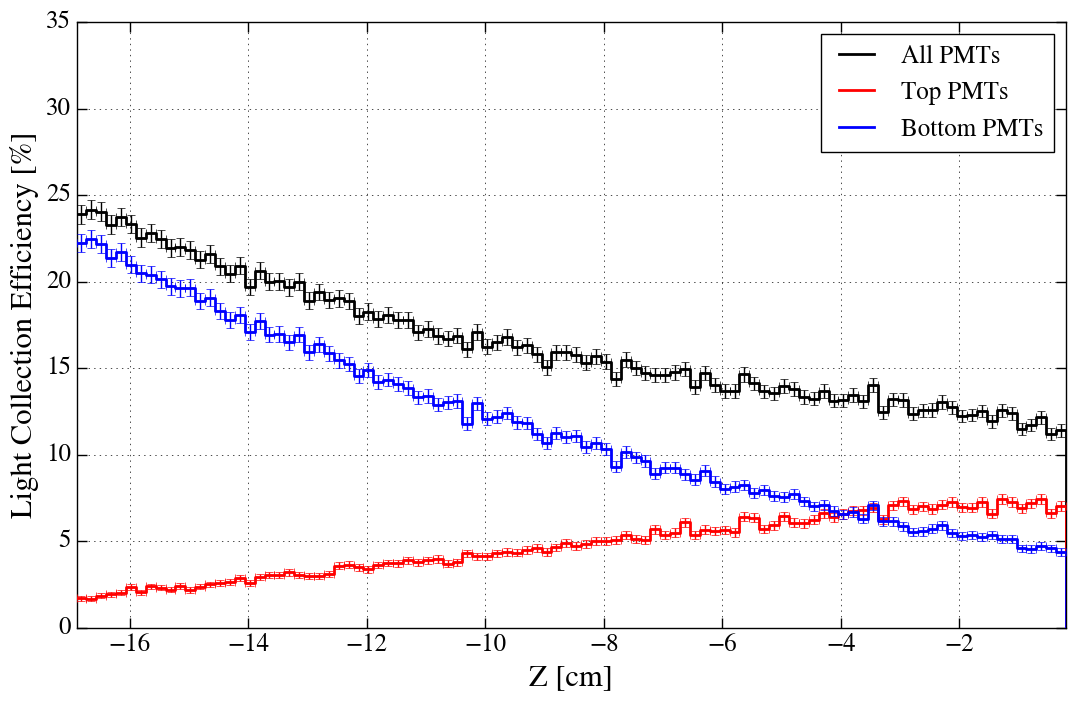

In [63]:
# Plot 1D LCE vs. Z
name = MC_name+"_H1D_LCE_Z"
Cut = TPC_Cut
xBins = [nbinsZ, LXe_minZ, LXe_maxZ]

# genereated photons
plot_name = name+"_gen"
ROOT.gDirectory.Delete(plot_name)
H1D_gen = Hist(xBins[0], xBins[1], xBins[2], name=plot_name)
dTC_MC.Draw('zp_pri/10.' + ' >> ' + plot_name, Cut, 'hist goff')

# detected top+bottom
plot_name = name+"_det"
ROOT.gDirectory.Delete(plot_name)
H1D_det = Hist(xBins[0], xBins[1], xBins[2], name=plot_name, 
               color='black', linewidth=2, linestyle='1', title='All PMTs')
dTC_MC.Draw('zp_pri/10.' + ' >> ' + plot_name, Cut+' && (ntpmthits > 0 || nbpmthits > 0)', 'hist goff')

# detected top
plot_name = name+"_det_top"
ROOT.gDirectory.Delete(plot_name)
H1D_det_top = Hist(xBins[0], xBins[1], xBins[2], name=plot_name, 
                   color='red', linewidth=2, linestyle='1', title='Top PMTs')
dTC_MC.Draw('zp_pri/10.' + ' >> ' + plot_name, Cut+' && ntpmthits > 0', 'hist goff')

# detected bottom
plot_name = name+"_det_bottom"
ROOT.gDirectory.Delete(plot_name)
H1D_det_bottom = Hist(xBins[0], xBins[1], xBins[2], name=plot_name, 
                      color='blue', linewidth=2, linestyle='1', title='Bottom PMTs')
dTC_MC.Draw('zp_pri/10.' + ' >> ' + plot_name, Cut+' && nbpmthits > 0', 'hist goff')

# Calculate and plot LCE
H1D_LCE_det = H1D_det.Clone()
H1D_LCE_det.Sumw2()
H1D_LCE_det.Divide(H1D_gen)
H1D_LCE_det.Scale(100)

H1D_LCE_det_top = H1D_det_top.Clone()
H1D_LCE_det_top.Sumw2()
H1D_LCE_det_top.Divide(H1D_gen)
H1D_LCE_det_top.Scale(100)

H1D_LCE_det_bottom = H1D_det_bottom.Clone()
H1D_LCE_det_bottom.Sumw2()
H1D_LCE_det_bottom.Divide(H1D_gen)
H1D_LCE_det_bottom.Scale(100)

fig = plt.figure()
rplt.hist(H1D_LCE_det)
rplt.errorbar(H1D_LCE_det, fmt=None, label="")
rplt.hist(H1D_LCE_det_top)
rplt.errorbar(H1D_LCE_det_top, fmt=None, label="")
rplt.hist(H1D_LCE_det_bottom)
rplt.errorbar(H1D_LCE_det_bottom, fmt=None, label="")

axes = plt.gca()
axes.set_ylim([0.,35.])

plt.xlabel("Z [cm]")
plt.ylabel("Light Collection Efficiency [%]")

plt.grid()
plt.legend()
plt.plot()
plt.savefig(Nb_directory+"/"+name+".pdf")
plt.savefig(Nb_directory+'/'+name+'.png')

fig = plt.figure()
Mean_LCE = np.ma.masked_equal([H1D_LCE_det.GetBinContent(x) for x in range(0,xBins[0])], 0).mean(axis=0)
H1D_LCE_det.Scale(1./Mean_LCE)
H1D_LCE_det_top.Scale(1./Mean_LCE)
H1D_LCE_det_bottom.Scale(1./Mean_LCE)
rplt.hist(H1D_LCE_det)
rplt.errorbar(H1D_LCE_det, fmt=None, label="")
rplt.hist(H1D_LCE_det_top)
rplt.errorbar(H1D_LCE_det_top, fmt=None, label="")
rplt.hist(H1D_LCE_det_bottom)
rplt.errorbar(H1D_LCE_det_bottom, fmt=None, label="")

axes = plt.gca()
axes.set_ylim([0.,1.5])

plt.xlabel("Z [cm]")
plt.ylabel("relative Light Collection Efficiency [%]")

plt.grid()
plt.legend()
plt.plot()
plt.savefig(Nb_directory+"/"+MC_name+"_H1D_rLCE_Z"+".pdf")
plt.savefig(Nb_directory+'/'+MC_name+"_H1D_rLCE_Z"+'.png')
plt.close(fig)

plt.show()

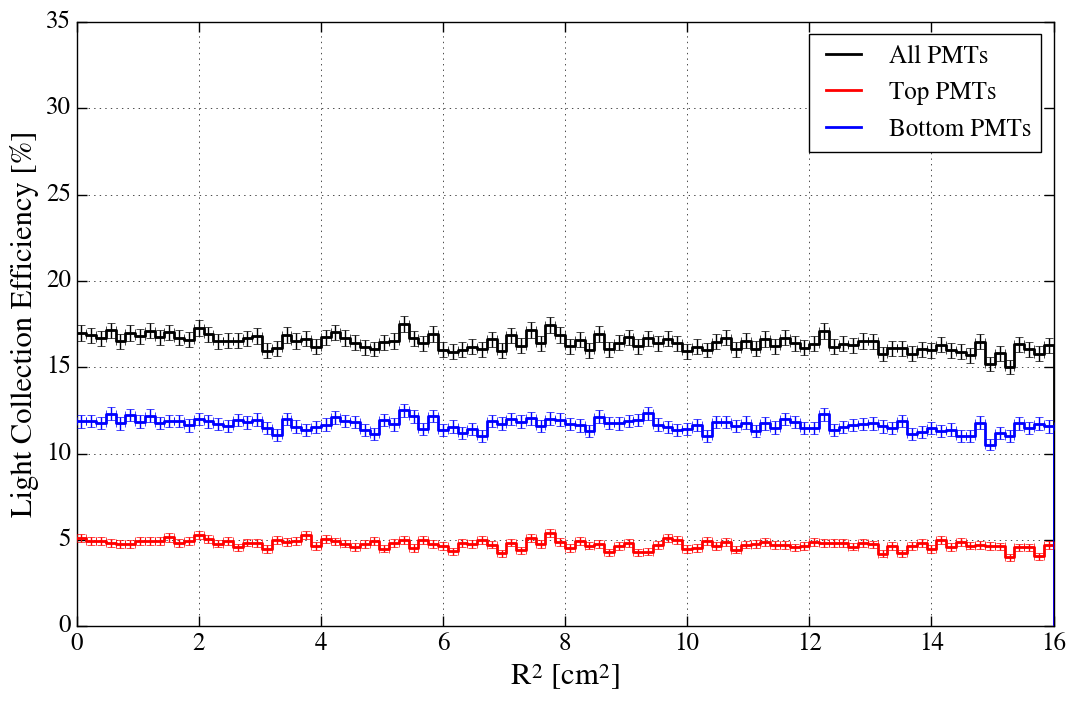

In [64]:
# Plot 1D LCE vs. RR
name = MC_name+"_H1D_LCE_RR"
Cut = TPC_Cut
xBins = [nbinsRR, LXe_minRR, LXe_maxRR]

# genereated photons
plot_name = name+"_gen"
ROOT.gDirectory.Delete(plot_name)
H1D_gen = Hist(xBins[0], xBins[1], xBins[2], name=plot_name)
dTC_MC.Draw('rrp_pri/10.' + ' >> ' + plot_name, Cut, 'goff')

# detected top+bottom
plot_name = name+"_det"
ROOT.gDirectory.Delete(plot_name)
H1D_det = Hist(xBins[0], xBins[1], xBins[2], name=plot_name, 
               color='black', linewidth=2, linestyle='1', title='All PMTs')
dTC_MC.Draw('rrp_pri/10.' + ' >> ' + plot_name, Cut+' && (ntpmthits > 0 || nbpmthits > 0)', 'goff')

# detected top
plot_name = name+"_det_top"
ROOT.gDirectory.Delete(plot_name)
H1D_det_top = Hist(xBins[0], xBins[1], xBins[2], name=plot_name, 
                   color='red', linewidth=2, linestyle='1', title='Top PMTs')
dTC_MC.Draw('rrp_pri/10.' + ' >> ' + plot_name, Cut+' && ntpmthits > 0', 'goff')

# detected bottom
plot_name = name+"_det_bottom"
ROOT.gDirectory.Delete(plot_name)
H1D_det_bottom = Hist(xBins[0], xBins[1], xBins[2], name=plot_name, 
                      color='blue', linewidth=2, linestyle='1', title='Bottom PMTs')
dTC_MC.Draw('rrp_pri/10.' + ' >> ' + plot_name, Cut+' && nbpmthits > 0', 'goff')

# Calculate and plot LCE
H1D_LCE_det = H1D_det.Clone()
H1D_LCE_det.Sumw2()
H1D_LCE_det.Divide(H1D_gen)
H1D_LCE_det.Scale(100)

H1D_LCE_det_top = H1D_det_top.Clone()
H1D_LCE_det_top.Sumw2()
H1D_LCE_det_top.Divide(H1D_gen)
H1D_LCE_det_top.Scale(100)

H1D_LCE_det_bottom = H1D_det_bottom.Clone()
H1D_LCE_det_bottom.Sumw2()
H1D_LCE_det_bottom.Divide(H1D_gen)
H1D_LCE_det_bottom.Scale(100)

fig = plt.figure()
rplt.hist(H1D_LCE_det)
rplt.errorbar(H1D_LCE_det, fmt=None, label="")
rplt.hist(H1D_LCE_det_top)
rplt.errorbar(H1D_LCE_det_top, fmt=None, label="")
rplt.hist(H1D_LCE_det_bottom)
rplt.errorbar(H1D_LCE_det_bottom, fmt=None, label="")

axes = plt.gca()
axes.set_ylim([0.,35.])

plt.xlabel("R$^2$ [cm$^2$]")
plt.ylabel("Light Collection Efficiency [%]")

plt.grid()
plt.legend()
plt.plot()
plt.savefig(Nb_directory+"/"+name+".pdf")
plt.savefig(Nb_directory+'/'+name+'.png')

plt.show()

### 2D Light Collection Efficiency

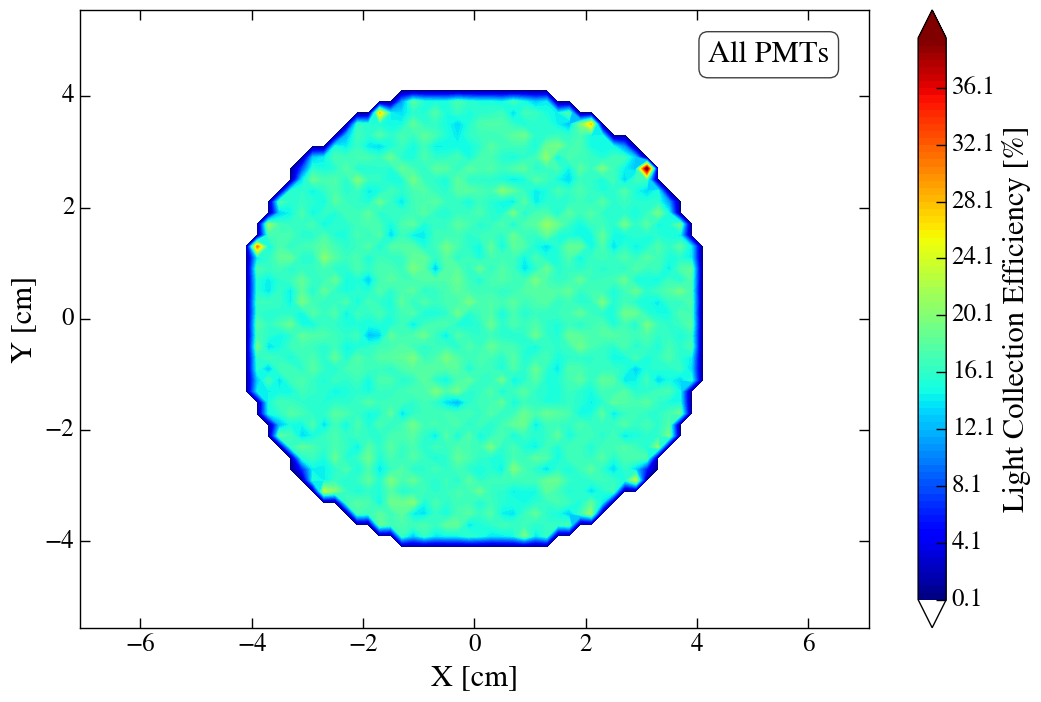

In [72]:
# Plot 2D LCE XY
name = MC_name+"_H2D_LCE_XY"
Cut = TPC_Cut
xBins = [50, LXe_minR-1, LXe_maxR+1]
yBins = [50, LXe_minR-1, LXe_maxR+1]

def gauss(x, maximum_y, maximum_x, sigma):
    return maximum_y*np.exp(-(maximum_x-x)**2/(2*sigma**2))

# genereated photons
plot_name = name+"_gen"
ROOT.gDirectory.Delete(plot_name)
H2D_gen = Hist2D(xBins[0], xBins[1], xBins[2], yBins[0], yBins[1], yBins[2], name=plot_name)
dTC_MC.Draw('yp_pri/10. : xp_pri/10.' + ' >> ' + plot_name, Cut, 'goff')

# detected top+bottom
plot_name = name+"_det"
ROOT.gDirectory.Delete(plot_name)
H2D_det = Hist2D(xBins[0], xBins[1], xBins[2], yBins[0], yBins[1], yBins[2], name=plot_name,)
dTC_MC.Draw('yp_pri/10. : xp_pri/10.' + ' >> ' + plot_name, Cut+' && (ntpmthits > 0 || nbpmthits > 0)', 'goff')

# detected top
plot_name = name+"_det_top"
ROOT.gDirectory.Delete(plot_name)
H2D_det_top = Hist2D(xBins[0], xBins[1], xBins[2], yBins[0], yBins[1], yBins[2], name=plot_name,)
dTC_MC.Draw('yp_pri/10. : xp_pri/10.' + ' >> ' + plot_name, Cut+' && ntpmthits > 0', 'goff')

# detected bottom
plot_name = name+"_det_bottom"
ROOT.gDirectory.Delete(plot_name)
H2D_det_bottom = Hist2D(xBins[0], xBins[1], xBins[2], yBins[0], yBins[1], yBins[2], name=plot_name,)
dTC_MC.Draw('yp_pri/10. : xp_pri/10.' + ' >> ' + plot_name, Cut+' && nbpmthits > 0', 'goff')

# Calculate and plot LCE
H2D_LCE_det = H2D_det.Clone()
H2D_LCE_det.Sumw2()
H2D_LCE_det.Divide(H2D_gen)
H2D_LCE_det.Scale(100)

H2D_LCE_det_top = H2D_det_top.Clone()
H2D_LCE_det_top.Sumw2()
H2D_LCE_det_top.Divide(H2D_gen)
H2D_LCE_det_top.Scale(100)

H2D_LCE_det_bottom = H2D_det_bottom.Clone()
H2D_LCE_det_bottom.Sumw2()
H2D_LCE_det_bottom.Divide(H2D_gen)
H2D_LCE_det_bottom.Scale(100)

fig = plt.figure()
H2D = H2D_LCE_det
x = np.array(list(H2D.x()))
y = np.array(list(H2D.y()))
z = np.array(H2D.z()).T
n = np.histogram(z.ravel(), np.linspace(0, 100, 500))
#popt, pcov = curve_fit(gauss, 0.5 * (n[1][:-1] + n[1][1:]), n[0], p0 = [max(n[0]), n[1][n[0].argmax(axis=0)], 15])
#steps = np.arange(math.floor(min([b for b in 0.5 * (n[1][:-1] + n[1][1:]) if gauss(b, *popt) >=1 and b >0.1])),
#                  math.ceil(max([b for b in 0.5 * (n[1][:-1] + n[1][1:]) if gauss(b, *popt) >=1 and b >0.1])), 0.5)
steps = np.arange(0.1,40,0.5)
#plt.contour(x,y,z,steps,linewidths=0.5,colors='k',vmin=100./steps)
im = plt.contourf(x,y,z,steps,vmin=steps[0],extend='both')
#counts, xedges, yedges, im = rplt.hist2d(H2D,vmin=0.000000001)
plt.colorbar(im, label="Light Collection Efficiency [%]")

axes = plt.gca()
axes.text(0.95, 0.95, "All PMTs", transform=axes.transAxes, horizontalalignment='right',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

plt.xlabel("X [cm]")
plt.ylabel("Y [cm]")

plt.axis('equal')
plt.plot()
plt.savefig(Nb_directory+"/"+name+"_All.pdf")
plt.savefig(Nb_directory+'/'+name+'_All.png')

fig = plt.figure()
H2D = H2D_LCE_det_top
x = np.array(list(H2D.x()))
y = np.array(list(H2D.y()))
z = np.array(H2D.z()).T
n = np.histogram(z.ravel(), np.linspace(0, 100, 500))
#popt, pcov = curve_fit(gauss, 0.5 * (n[1][:-1] + n[1][1:]), n[0], p0 = [max(n[0]), n[1][n[0].argmax(axis=0)], 15])
#steps = np.arange(math.floor(min([b for b in 0.5 * (n[1][:-1] + n[1][1:]) if gauss(b, *popt) >=1 and b >0.1])),
#                  math.ceil(max([b for b in 0.5 * (n[1][:-1] + n[1][1:]) if gauss(b, *popt) >=1 and b >0.1])), 0.5)
steps = np.arange(0.1,40,0.5)
#plt.contour(x,y,z,steps,linewidths=0.5,colors='k',vmin=100./steps)
im = plt.contourf(x,y,z,steps,vmin=steps[0],extend='both')
#counts, xedges, yedges, im = rplt.hist2d(H2D,vmin=0.000000001)
plt.colorbar(im, label="Light Collection Efficiency [%]")

axes = plt.gca()
axes.text(0.95, 0.95, "Top PMTs", transform=axes.transAxes, horizontalalignment='right',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

plt.xlabel("X [cm]")
plt.ylabel("Y [cm]")

plt.axis('equal')
plt.plot()
plt.savefig(Nb_directory+"/"+name+"_Top.pdf")
plt.savefig(Nb_directory+'/'+name+'_Top.png')
plt.close(fig)

fig = plt.figure()
H2D = H2D_LCE_det_bottom
x = np.array(list(H2D.x()))
y = np.array(list(H2D.y()))
z = np.array(H2D.z()).T
n = np.histogram(z.ravel(), np.linspace(0, 100, 500))
#popt, pcov = curve_fit(gauss, 0.5 * (n[1][:-1] + n[1][1:]), n[0], p0 = [max(n[0]), n[1][n[0].argmax(axis=0)], 15])
#steps = np.arange(math.floor(min([b for b in 0.5 * (n[1][:-1] + n[1][1:]) if gauss(b, *popt) >=1 and b >0.1])),
#                  math.ceil(max([b for b in 0.5 * (n[1][:-1] + n[1][1:]) if gauss(b, *popt) >=1 and b >0.1])), 0.5)
steps = np.arange(0.1,40,0.5)
#plt.contour(x,y,z,steps,linewidths=0.5,colors='k',vmin=100./steps)
im = plt.contourf(x,y,z,steps,vmin=steps[0],extend='both')
#counts, xedges, yedges, im = rplt.hist2d(H2D,vmin=0.000000001)
plt.colorbar(im, label="Light Collection Efficiency [%]")

axes = plt.gca()
axes.text(0.95, 0.95, "Bottom PMTs", transform=axes.transAxes, horizontalalignment='right',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

plt.xlabel("X [cm]")
plt.ylabel("Y [cm]")

plt.axis('equal')
plt.plot()
plt.savefig(Nb_directory+"/"+name+"_Bottom.pdf")
plt.savefig(Nb_directory+'/'+name+'_Bottom.png')
plt.close(fig)

plt.show()

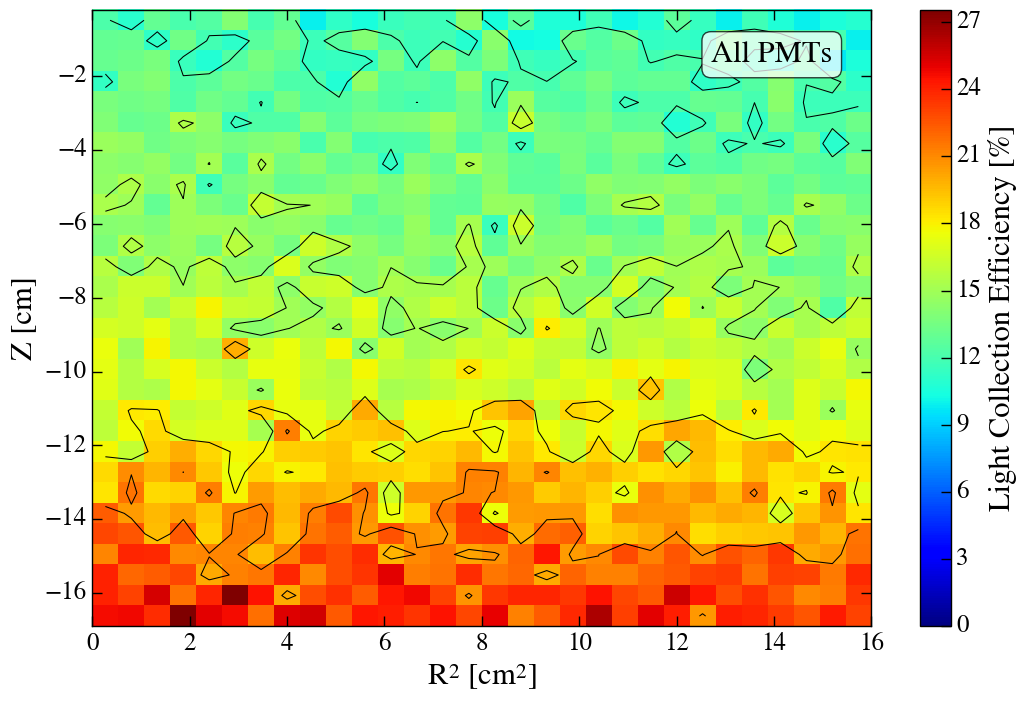

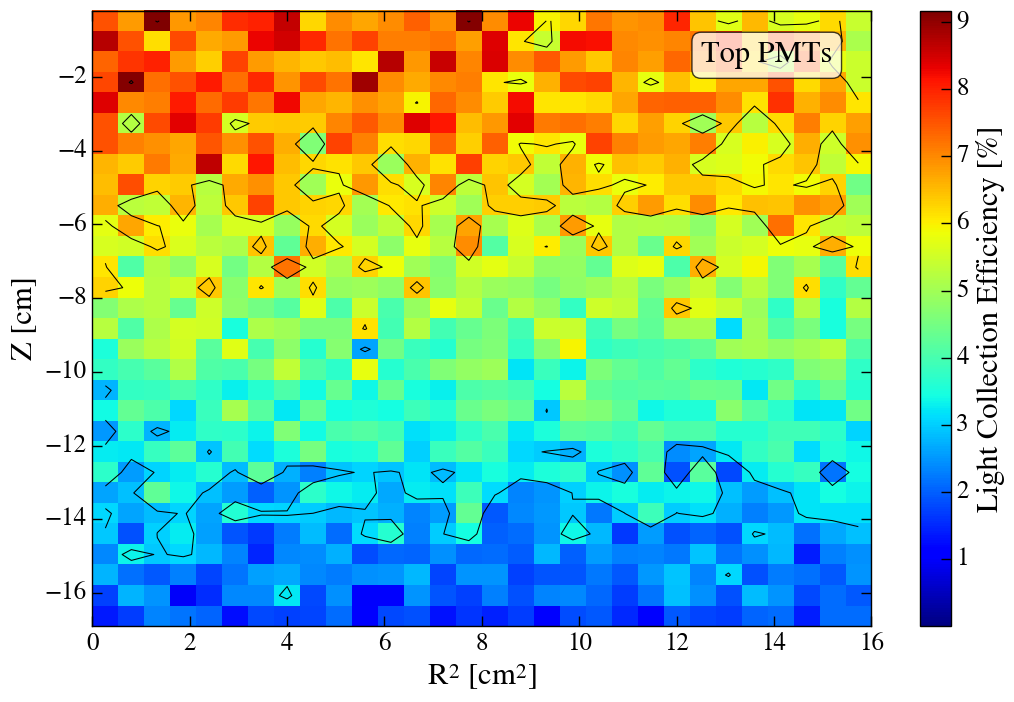

In [66]:
# Plot 2D LCE RRZ
name = MC_name+"_H2D_LCE_RRZ"
Cut = TPC_Cut
xBins = [30, LXe_minRR, LXe_maxRR]
yBins = [30, LXe_minZ, LXe_maxZ]

def gauss(x, maximum_y, maximum_x, sigma):
    return maximum_y*np.exp(-(maximum_x-x)**2/(2*sigma**2))

# genereated photons
plot_name = name+"_gen"
ROOT.gDirectory.Delete(plot_name)
H2D_gen = Hist2D(xBins[0], xBins[1], xBins[2], yBins[0], yBins[1], yBins[2], name=plot_name)
dTC_MC.Draw('zp_pri/10. : rrp_pri/10.' + ' >> ' + plot_name, Cut, 'goff')

# detected top+bottom
plot_name = name+"_det"
ROOT.gDirectory.Delete(plot_name)
H2D_det = Hist2D(xBins[0], xBins[1], xBins[2], yBins[0], yBins[1], yBins[2], name=plot_name,)
dTC_MC.Draw('zp_pri/10. : rrp_pri/10.' + ' >> ' + plot_name, Cut+' && (ntpmthits > 0 || nbpmthits > 0)', 'goff')

# detected top
plot_name = name+"_det_top"
ROOT.gDirectory.Delete(plot_name)
H2D_det_top = Hist2D(xBins[0], xBins[1], xBins[2], yBins[0], yBins[1], yBins[2], name=plot_name,)
dTC_MC.Draw('zp_pri/10. : rrp_pri/10.' + ' >> ' + plot_name, Cut+' && ntpmthits > 0', 'goff')

# detected bottom
plot_name = name+"_det_bottom"
ROOT.gDirectory.Delete(plot_name)
H2D_det_bottom = Hist2D(xBins[0], xBins[1], xBins[2], yBins[0], yBins[1], yBins[2], name=plot_name,)
dTC_MC.Draw('zp_pri/10. : rrp_pri/10.' + ' >> ' + plot_name, Cut+' && nbpmthits > 0', 'goff')

# Calculate and plot LCE
H2D_LCE_det = H2D_det.Clone()
H2D_LCE_det.Sumw2()
H2D_LCE_det.Divide(H2D_gen)
H2D_LCE_det.Scale(100)

H2D_LCE_det_top = H2D_det_top.Clone()
H2D_LCE_det_top.Sumw2()
H2D_LCE_det_top.Divide(H2D_gen)
H2D_LCE_det_top.Scale(100)

H2D_LCE_det_bottom = H2D_det_bottom.Clone()
H2D_LCE_det_bottom.Sumw2()
H2D_LCE_det_bottom.Divide(H2D_gen)
H2D_LCE_det_bottom.Scale(100)

fig = plt.figure()
H2D = H2D_LCE_det
x = np.array(list(H2D.x()))
y = np.array(list(H2D.y()))
z = np.array(H2D.z()).T
n = np.histogram(z.ravel(), np.linspace(0, 100, 500))
popt, pcov = curve_fit(gauss, 0.5 * (n[1][:-1] + n[1][1:]), n[0], p0 = [max(n[0]), n[1][n[0].argmax(axis=0)], 15])
steps = np.arange(math.floor(min([b for b in 0.5 * (n[1][:-1] + n[1][1:]) if gauss(b, *popt) >=1 and b >0.1])),
                  math.ceil(max([b for b in 0.5 * (n[1][:-1] + n[1][1:]) if gauss(b, *popt) >=1 and b >0.1])), 3)
counts, xedges, yedges, im = rplt.hist2d(H2D,vmin=0.000000001)
plt.contour(x,y,z,steps,linewidths=0.75,colors='k')
#im = plt.contourf(x,y,z,steps,vmin=steps[0],extend='both', alpha=1)
plt.colorbar(im, label="Light Collection Efficiency [%]")

axes = plt.gca()
axes.text(0.95, 0.95, "All PMTs", transform=axes.transAxes, horizontalalignment='right',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

plt.title("")
plt.xlabel("R$^2$ [cm$^2$]")
plt.ylabel("Z [cm]")

plt.plot()
plt.savefig(Nb_directory+"/"+name+"_All.pdf")
plt.savefig(Nb_directory+'/'+name+'_All.png')

fig = plt.figure()
H2D = H2D_LCE_det_top
x = np.array(list(H2D.x()))
y = np.array(list(H2D.y()))
z = np.array(H2D.z()).T
n = np.histogram(z.ravel(), np.linspace(0, 100, 500))
popt, pcov = curve_fit(gauss, 0.5 * (n[1][:-1] + n[1][1:]), n[0], p0 = [max(n[0]), n[1][n[0].argmax(axis=0)], 15])
steps = np.arange(math.floor(min([b for b in 0.5 * (n[1][:-1] + n[1][1:]) if gauss(b, *popt) >=1 and b >0.1])),
                  math.ceil(max([b for b in 0.5 * (n[1][:-1] + n[1][1:]) if gauss(b, *popt) >=1 and b >0.1])), 3)
counts, xedges, yedges, im = rplt.hist2d(H2D,vmin=0.000000001)
plt.contour(x,y,z,steps,linewidths=0.75,colors='k')
#im = plt.contourf(x,y,z,steps,vmin=steps[0],extend='both', alpha=1)
plt.colorbar(im, label="Light Collection Efficiency [%]")

axes = plt.gca()
axes.text(0.95, 0.95, "Top PMTs", transform=axes.transAxes, horizontalalignment='right',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

plt.title("")
plt.xlabel("R$^2$ [cm$^2$]")
plt.ylabel("Z [cm]")

plt.plot()
plt.savefig(Nb_directory+"/"+name+"_Top.pdf")
plt.savefig(Nb_directory+'/'+name+'_Top.png')

fig = plt.figure()
H2D = H2D_LCE_det_bottom
x = np.array(list(H2D.x()))
y = np.array(list(H2D.y()))
z = np.array(H2D.z()).T
n = np.histogram(z.ravel(), np.linspace(0, 100, 500))
popt, pcov = curve_fit(gauss, 0.5 * (n[1][:-1] + n[1][1:]), n[0], p0 = [max(n[0]), n[1][n[0].argmax(axis=0)], 15])
steps = np.arange(math.floor(min([b for b in 0.5 * (n[1][:-1] + n[1][1:]) if gauss(b, *popt) >=1 and b >0.1])),
                  math.ceil(max([b for b in 0.5 * (n[1][:-1] + n[1][1:]) if gauss(b, *popt) >=1 and b >0.1])), 3)
counts, xedges, yedges, im = rplt.hist2d(H2D,vmin=0.000000001)
plt.contour(x,y,z,steps,linewidths=0.75,colors='k')
#im = plt.contourf(x,y,z,steps,vmin=steps[0],extend='both', alpha=1)
plt.colorbar(im, label="Light Collection Efficiency [%]")

axes = plt.gca()
axes.text(0.95, 0.95, "Bottom PMTs", transform=axes.transAxes, horizontalalignment='right',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

plt.title("")
plt.xlabel("R$^2$ [cm$^2$]")
plt.ylabel("Z [cm]")

plt.plot()
plt.savefig(Nb_directory+"/"+name+"_Bottom.pdf")
plt.savefig(Nb_directory+'/'+name+'_Bottom.png')
plt.close(fig)

name = MC_name+"_H2D_rLCE_RRZ"
Mean_LCE = np.ma.masked_equal([H2D_LCE_det.GetBinContent(x) for x in range(0,xBins[0]*yBins[0])], 0).mean(axis=0)
H2D_LCE_det.Scale(1./Mean_LCE)
H2D_LCE_det_top.Scale(1./Mean_LCE)
H2D_LCE_det_bottom.Scale(1./Mean_LCE)

fig = plt.figure()
H2D = H2D_LCE_det
x = np.array(list(H2D.x()))
y = np.array(list(H2D.y()))
z = np.array(H2D.z()).T
n = np.histogram(z.ravel(), np.linspace(0, 100, 500))
popt, pcov = curve_fit(gauss, 0.5 * (n[1][:-1] + n[1][1:]), n[0], p0 = [max(n[0]), n[1][n[0].argmax(axis=0)], 15])
steps = np.arange(math.floor(min([b for b in 0.5 * (n[1][:-1] + n[1][1:]) if gauss(b, *popt) >=1 and b >0.1])),
                  math.ceil(max([b for b in 0.5 * (n[1][:-1] + n[1][1:]) if gauss(b, *popt) >=1 and b >0.1])), 0.1)
counts, xedges, yedges, im = rplt.hist2d(H2D,vmin=0.000000001)
plt.contour(x,y,z,steps,linewidths=0.75,colors='k')
#im = plt.contourf(x,y,z,steps,vmin=steps[0],extend='both', alpha=1)
plt.colorbar(im, label="relative Light Collection Efficiency [%]")

axes = plt.gca()
axes.text(0.95, 0.95, "All PMTs", transform=axes.transAxes, horizontalalignment='right',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

plt.title("")
plt.xlabel("R$^2$ [cm$^2$]")
plt.ylabel("Z [cm]")

plt.plot()
plt.savefig(Nb_directory+"/"+name+"_All.pdf")
plt.savefig(Nb_directory+'/'+name+'_All.png')
plt.close(fig)

fig = plt.figure()
H2D = H2D_LCE_det_top
x = np.array(list(H2D.x()))
y = np.array(list(H2D.y()))
z = np.array(H2D.z()).T
n = np.histogram(z.ravel(), np.linspace(0, 100, 500))
popt, pcov = curve_fit(gauss, 0.5 * (n[1][:-1] + n[1][1:]), n[0], p0 = [max(n[0]), n[1][n[0].argmax(axis=0)], 15])
steps = np.arange(math.floor(min([b for b in 0.5 * (n[1][:-1] + n[1][1:]) if gauss(b, *popt) >=1 and b >0.1])),
                  math.ceil(max([b for b in 0.5 * (n[1][:-1] + n[1][1:]) if gauss(b, *popt) >=1 and b >0.1])), 0.1)
counts, xedges, yedges, im = rplt.hist2d(H2D,vmin=0.000000001)
plt.contour(x,y,z,steps,linewidths=0.75,colors='k')
#im = plt.contourf(x,y,z,steps,vmin=steps[0],extend='both', alpha=1)
plt.colorbar(im, label="relative Light Collection Efficiency [%]")

axes = plt.gca()
axes.text(0.95, 0.95, "Top PMTs", transform=axes.transAxes, horizontalalignment='right',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

plt.title("")
plt.xlabel("R$^2$ [cm$^2$]")
plt.ylabel("Z [cm]")

plt.plot()
plt.savefig(Nb_directory+"/"+name+"_Top.pdf")
plt.savefig(Nb_directory+'/'+name+'_Top.png')
plt.close(fig)

fig = plt.figure()
H2D = H2D_LCE_det_bottom
x = np.array(list(H2D.x()))
y = np.array(list(H2D.y()))
z = np.array(H2D.z()).T
n = np.histogram(z.ravel(), np.linspace(0, 100, 500))
popt, pcov = curve_fit(gauss, 0.5 * (n[1][:-1] + n[1][1:]), n[0], p0 = [max(n[0]), n[1][n[0].argmax(axis=0)], 15])
steps = np.arange(math.floor(min([b for b in 0.5 * (n[1][:-1] + n[1][1:]) if gauss(b, *popt) >=1 and b >0.1])),
                  math.ceil(max([b for b in 0.5 * (n[1][:-1] + n[1][1:]) if gauss(b, *popt) >=1 and b >0.1])), 0.1)
counts, xedges, yedges, im = rplt.hist2d(H2D,vmin=0.000000001)
plt.contour(x,y,z,steps,linewidths=0.75,colors='k')
#im = plt.contourf(x,y,z,steps,vmin=steps[0],extend='both', alpha=1)
plt.colorbar(im, label="relative Light Collection Efficiency [%]")

axes = plt.gca()
axes.text(0.95, 0.95, "Bottom PMTs", transform=axes.transAxes, horizontalalignment='right',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

plt.title("")
plt.xlabel("R$^2$ [cm$^2$]")
plt.ylabel("Z [cm]")

plt.plot()
plt.savefig(Nb_directory+"/"+name+"_Bottom.pdf")
plt.savefig(Nb_directory+'/'+name+'_Bottom.png')
plt.close(fig)

plt.show()

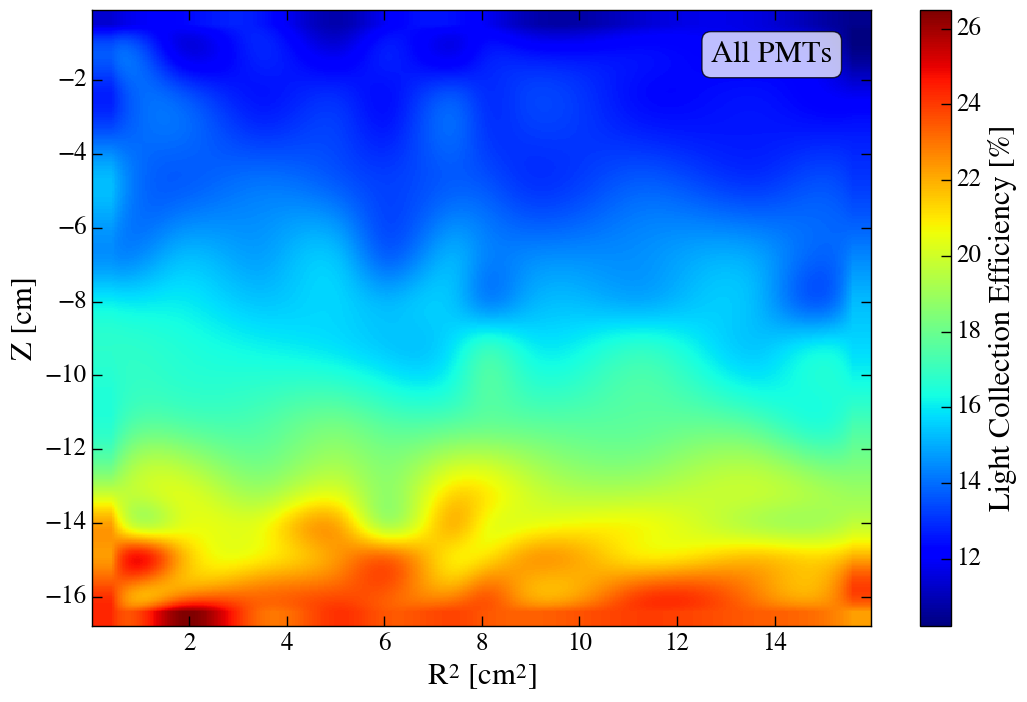

In [67]:
# Plot 2D LCE RRZ interpolation
name = MC_name+"_H2D_LCE_RRZ_INTERP"
Cut = TPC_Cut
nxbins = 20
nybins = 20
xBins = [nxbins, LXe_minRR, LXe_maxRR]
yBins = [nybins, LXe_minZ, LXe_maxZ]

def gauss(x, maximum_y, maximum_x, sigma):
    return maximum_y*np.exp(-(maximum_x-x)**2/(2*sigma**2))

# genereated photons
plot_name = name+"_gen"
ROOT.gDirectory.Delete(plot_name)
H2D_gen = Hist2D(xBins[0], xBins[1], xBins[2], yBins[0], yBins[1], yBins[2], name=plot_name)
dTC_MC.Draw('zp_pri/10. : rrp_pri/10.' + ' >> ' + plot_name, Cut, 'goff')

# detected top+bottom
plot_name = name+"_det"
ROOT.gDirectory.Delete(plot_name)
H2D_det = Hist2D(xBins[0], xBins[1], xBins[2], yBins[0], yBins[1], yBins[2], name=plot_name,)
dTC_MC.Draw('zp_pri/10. : rrp_pri/10.' + ' >> ' + plot_name, Cut+' && (ntpmthits > 0 || nbpmthits > 0)', 'goff')

# detected top
plot_name = name+"_det_top"
ROOT.gDirectory.Delete(plot_name)
H2D_det_top = Hist2D(xBins[0], xBins[1], xBins[2], yBins[0], yBins[1], yBins[2], name=plot_name,)
dTC_MC.Draw('zp_pri/10. : rrp_pri/10.' + ' >> ' + plot_name, Cut+' && ntpmthits > 0', 'goff')

# detected bottom
plot_name = name+"_det_bottom"
ROOT.gDirectory.Delete(plot_name)
H2D_det_bottom = Hist2D(xBins[0], xBins[1], xBins[2], yBins[0], yBins[1], yBins[2], name=plot_name,)
dTC_MC.Draw('zp_pri/10. : rrp_pri/10.' + ' >> ' + plot_name, Cut+' && nbpmthits > 0', 'goff')

# Calculate and plot LCE
H2D_LCE_det = H2D_det.Clone()
H2D_LCE_det.Sumw2()
H2D_LCE_det.Divide(H2D_gen)
H2D_LCE_det.Scale(100)

H2D_LCE_det_top = H2D_det_top.Clone()
H2D_LCE_det_top.Sumw2()
H2D_LCE_det_top.Divide(H2D_gen)
H2D_LCE_det_top.Scale(100)

H2D_LCE_det_bottom = H2D_det_bottom.Clone()
H2D_LCE_det_bottom.Sumw2()
H2D_LCE_det_bottom.Divide(H2D_gen)
H2D_LCE_det_bottom.Scale(100)

fig = plt.figure()
H2D = H2D_LCE_det
x = np.array(list(H2D.x()))
y = np.array(list(H2D.y()))
z = np.array(H2D.z()).T
yy = np.linspace(yBins[1],yBins[2],nybins+1)[:-1]-0.5*np.linspace(yBins[1],yBins[2],nybins+1)[-2]
yy = [yy] * nxbins
xx = np.linspace(xBins[1],xBins[2],nxbins+1)[1:]-0.5*np.linspace(xBins[1],xBins[2],nxbins+1)[1]
xx = [[xi] * nybins for xi in xx]
#plt.pcolor(xx, yy, z.T)
xbins = 500
ybins = 500
tck = interpolate.bisplrep(xx, yy, z, s=2)
newyy = np.linspace(yBins[1],yBins[2],ybins+1)[:-1]-0.5*np.linspace(yBins[1],yBins[2],ybins+1)[-2]
newxx = np.linspace(xBins[1],xBins[2],xbins+1)[1:]-0.5*np.linspace(xBins[1],xBins[2],xbins+1)[1]
znew = interpolate.bisplev(newxx[:], newyy[:], tck)
plt.pcolor(newxx, newyy, znew)
#plt.xlim(xBins[1], xBins[2])
#plt.ylim(yBins[1], yBins[2])
plt.colorbar(label="Light Collection Efficiency [%]")

axes = plt.gca()
axes.text(0.95, 0.95, "All PMTs", transform=axes.transAxes, horizontalalignment='right',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))
plt.axis('tight')

plt.xlabel("R$^2$ [cm$^2$]")
plt.ylabel("Z [cm]")
plt.savefig(Nb_directory+"/"+name+"_All.pdf")
plt.savefig(Nb_directory+'/'+name+'_All.png')
plt.plot()

plt.show()

### Hits fraction per PMT

In [68]:
# check PMT details and get PMT hits
name = MC_name+"_PMTpattern_hitsfraction"

plot_name = name+"_check"
ROOT.gDirectory.Delete(plot_name)
H2D_check = Hist2D(22, 0., 60.*60., 26, -140., 6., name=plot_name)
dTC_MC.Draw('zp_pri/10. : rrp_pri/10.' + ' >> ' + plot_name, "pmthits[0]>0", 'goff')
PMT_details = (H2D_check.GetEntries() != 0)

if (H2D_check.GetEntries() == 0):
    raise ValueError('No PMT details found!')

nbentries = dTC_MC.GetEntries()

pmthits = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0])
npmthits = 0
for event in dTC_MC:
    # This calculation works only with one simulated photon per event
    if ((dTC_MC.ntpmthits+dTC_MC.nbpmthits) > 1):
        raise ValueError('Only one photon per event is allowed!')

    if ((dTC_MC.ntpmthits+dTC_MC.nbpmthits) == 1):
        pmthits = pmthits + np.array(list(dTC_MC.pmthits))
        npmthits += 1

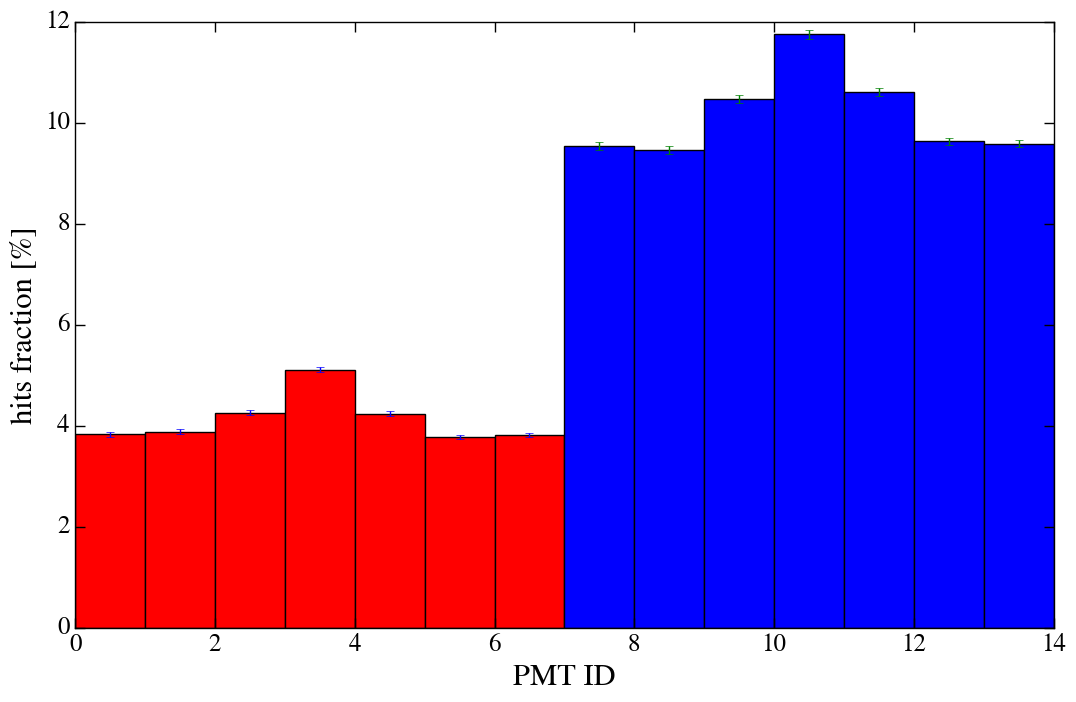

In [69]:
# PMT hits fraction
name = MC_name+"_PMTpattern_hitsfraction"

fig, ax = plt.subplots()
hitsfraction = ax.bar(np.arange(7), pmthits[:7]/npmthits*100., 1, color='r', yerr=np.sqrt(pmthits[:7])/npmthits*100.)
hitsfraction = ax.bar(np.arange(7,14), pmthits[7:]/npmthits*100., 1, color='b', yerr=np.sqrt(pmthits[7:])/npmthits*100.)

plt.xlabel("PMT ID")
plt.ylabel("hits fraction [%]")

plt.plot()
plt.savefig(Nb_directory+'/'+name+"_TopBottom.pdf")
plt.savefig(Nb_directory+'/'+name+'_TopBottom.png')

plt.show()

## S2 optical photon simulation

In [73]:
MC_name = 'optPhot_S2_1e5'
MC_title = 'S2 optical photon simulation with default optical settings'
MC_filename = ['/rootfiles/optPhot_S2_1e5.root']

remote_dirs = [Nb_directory+'/',
              '.']

for location in remote_dirs:
    if os.path.exists(location+MC_filename[0]):
        dTC_MC = dTChain([location+file for file in MC_filename])

In [74]:
Cut = TPC_Cut

dTC_MC.Draw(">>elist_gen",Cut,"goff")
elist_gen = ROOT.gDirectory.Get("elist_gen")
dTC_MC.Draw(">>elist_det",Cut+" && (nbpmthits > 0 || ntpmthits > 0)","goff")
elist_det = ROOT.gDirectory.Get("elist_det")
dTC_MC.Draw(">>elist_det_top",Cut+" && ntpmthits > 0","goff")
elist_det_top = ROOT.gDirectory.Get("elist_det_top")
dTC_MC.Draw(">>elist_det_bottom",Cut+" && nbpmthits > 0","goff")
elist_det_bottom = ROOT.gDirectory.Get("elist_det_bottom")

display(Markdown("""**Loaded MC data:**  
 Description: {0}  
 File(s)/folder: **{1}**  
 Events: {2}  
 
**Without PMT corrections:**  
 Detected events (All PMTs): {3}  
 Detected events (Top PMTs): {4}  
 Detected events (Bottom PMTs): {5}  
 
 Mean LCE (All PMTs): {6:2.2f}%  
 Mean LCE (Top PMTs): {7:2.2f}%  
 Mean LCE (Bottom PMTs): {8:2.2f}%  
 AreaFractionTop: {9:2.2f}%  
""".format(MC_title,MC_filename,dTC_MC.GetEntries(),elist_det.GetN(),
           elist_det_top.GetN(),elist_det_bottom.GetN(),elist_det.GetN()/elist_gen.GetN()*100.,
           elist_det_top.GetN()/elist_gen.GetN()*100.,elist_det_bottom.GetN()/elist_gen.GetN()*100.,
           elist_det_top.GetN()/elist_det.GetN()*100.)))

**Loaded MC data:**  
 Description: S2 optical photon simulation with default optical settings  
 File(s)/folder: **['/rootfiles/optPhot_S2_1e5.root']**  
 Events: 100000  
 
**Without PMT corrections:**  
 Detected events (All PMTs): 22191  
 Detected events (Top PMTs): 18347  
 Detected events (Bottom PMTs): 3844  
 
 Mean LCE (All PMTs): 22.19%  
 Mean LCE (Top PMTs): 18.35%  
 Mean LCE (Bottom PMTs): 3.84%  
 AreaFractionTop: 82.68%  


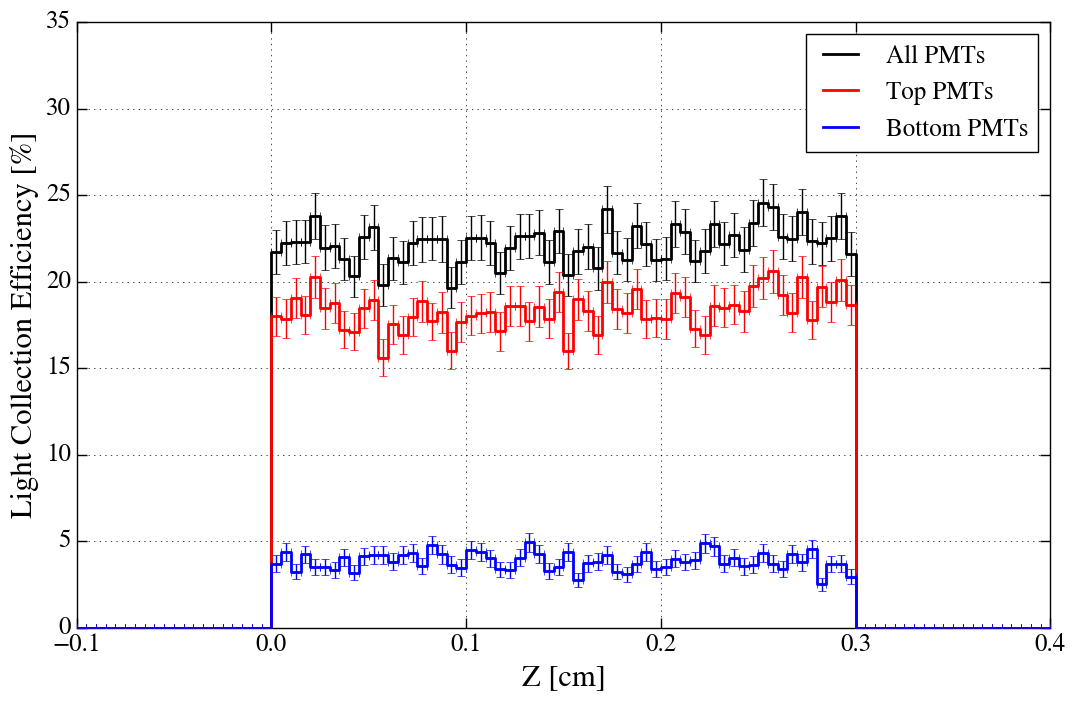

In [79]:
# Plot 1D LCE vs. Z
name = MC_name+"_H1D_LCE_Z"
Cut = TPC_Cut
xBins = [nbinsZ, -0.1,0.4]

# genereated photons
plot_name = name+"_gen"
ROOT.gDirectory.Delete(plot_name)
H1D_gen = Hist(xBins[0], xBins[1], xBins[2], name=plot_name)
dTC_MC.Draw('zp_pri/10.' + ' >> ' + plot_name, Cut, 'hist goff')

# detected top+bottom
plot_name = name+"_det"
ROOT.gDirectory.Delete(plot_name)
H1D_det = Hist(xBins[0], xBins[1], xBins[2], name=plot_name, 
               color='black', linewidth=2, linestyle='1', title='All PMTs')
dTC_MC.Draw('zp_pri/10.' + ' >> ' + plot_name, Cut+' && (ntpmthits > 0 || nbpmthits > 0)', 'hist goff')

# detected top
plot_name = name+"_det_top"
ROOT.gDirectory.Delete(plot_name)
H1D_det_top = Hist(xBins[0], xBins[1], xBins[2], name=plot_name, 
                   color='red', linewidth=2, linestyle='1', title='Top PMTs')
dTC_MC.Draw('zp_pri/10.' + ' >> ' + plot_name, Cut+' && ntpmthits > 0', 'hist goff')

# detected bottom
plot_name = name+"_det_bottom"
ROOT.gDirectory.Delete(plot_name)
H1D_det_bottom = Hist(xBins[0], xBins[1], xBins[2], name=plot_name, 
                      color='blue', linewidth=2, linestyle='1', title='Bottom PMTs')
dTC_MC.Draw('zp_pri/10.' + ' >> ' + plot_name, Cut+' && nbpmthits > 0', 'hist goff')

# Calculate and plot LCE
H1D_LCE_det = H1D_det.Clone()
H1D_LCE_det.Sumw2()
H1D_LCE_det.Divide(H1D_gen)
H1D_LCE_det.Scale(100)

H1D_LCE_det_top = H1D_det_top.Clone()
H1D_LCE_det_top.Sumw2()
H1D_LCE_det_top.Divide(H1D_gen)
H1D_LCE_det_top.Scale(100)

H1D_LCE_det_bottom = H1D_det_bottom.Clone()
H1D_LCE_det_bottom.Sumw2()
H1D_LCE_det_bottom.Divide(H1D_gen)
H1D_LCE_det_bottom.Scale(100)

fig = plt.figure()
rplt.hist(H1D_LCE_det)
rplt.errorbar(H1D_LCE_det, fmt=None, label="")
rplt.hist(H1D_LCE_det_top)
rplt.errorbar(H1D_LCE_det_top, fmt=None, label="")
rplt.hist(H1D_LCE_det_bottom)
rplt.errorbar(H1D_LCE_det_bottom, fmt=None, label="")

axes = plt.gca()
axes.set_ylim([0.,35.])

plt.xlabel("Z [cm]")
plt.ylabel("Light Collection Efficiency [%]")

plt.grid()
plt.legend()
plt.plot()
plt.savefig(Nb_directory+"/"+name+".pdf")
plt.savefig(Nb_directory+'/'+name+'.png')

fig = plt.figure()
Mean_LCE = np.ma.masked_equal([H1D_LCE_det.GetBinContent(x) for x in range(0,xBins[0])], 0).mean(axis=0)
H1D_LCE_det.Scale(1./Mean_LCE)
H1D_LCE_det_top.Scale(1./Mean_LCE)
H1D_LCE_det_bottom.Scale(1./Mean_LCE)
rplt.hist(H1D_LCE_det)
rplt.errorbar(H1D_LCE_det, fmt=None, label="")
rplt.hist(H1D_LCE_det_top)
rplt.errorbar(H1D_LCE_det_top, fmt=None, label="")
rplt.hist(H1D_LCE_det_bottom)
rplt.errorbar(H1D_LCE_det_bottom, fmt=None, label="")

axes = plt.gca()
axes.set_ylim([0.,1.5])

plt.xlabel("Z [cm]")
plt.ylabel("relative Light Collection Efficiency [%]")

plt.grid()
plt.legend()
plt.plot()
plt.savefig(Nb_directory+"/"+MC_name+"_H1D_rLCE_Z"+".pdf")
plt.savefig(Nb_directory+'/'+MC_name+"_H1D_rLCE_Z"+'.png')
plt.close(fig)

plt.show()

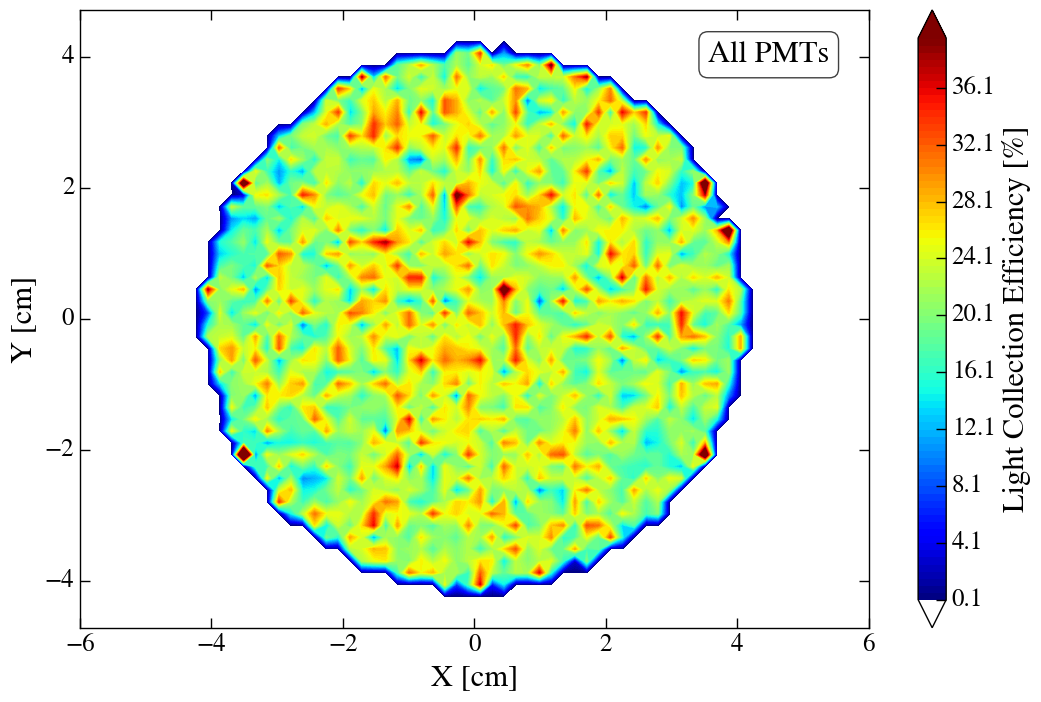

In [75]:
# Plot 2D LCE XY
name = MC_name+"_H2D_LCE_XY"
Cut = TPC_Cut
xBins = [50, LXe_minR-0.5, LXe_maxR+0.5]
yBins = [50, LXe_minR-0.5, LXe_maxR+0.5]

def gauss(x, maximum_y, maximum_x, sigma):
    return maximum_y*np.exp(-(maximum_x-x)**2/(2*sigma**2))

# genereated photons
plot_name = name+"_gen"
ROOT.gDirectory.Delete(plot_name)
H2D_gen = Hist2D(xBins[0], xBins[1], xBins[2], yBins[0], yBins[1], yBins[2], name=plot_name)
dTC_MC.Draw('yp_pri/10. : xp_pri/10.' + ' >> ' + plot_name, Cut, 'goff')

# detected top+bottom
plot_name = name+"_det"
ROOT.gDirectory.Delete(plot_name)
H2D_det = Hist2D(xBins[0], xBins[1], xBins[2], yBins[0], yBins[1], yBins[2], name=plot_name,)
dTC_MC.Draw('yp_pri/10. : xp_pri/10.' + ' >> ' + plot_name, Cut+' && (ntpmthits > 0 || nbpmthits > 0)', 'goff')

# detected top
plot_name = name+"_det_top"
ROOT.gDirectory.Delete(plot_name)
H2D_det_top = Hist2D(xBins[0], xBins[1], xBins[2], yBins[0], yBins[1], yBins[2], name=plot_name,)
dTC_MC.Draw('yp_pri/10. : xp_pri/10.' + ' >> ' + plot_name, Cut+' && ntpmthits > 0', 'goff')

# detected bottom
plot_name = name+"_det_bottom"
ROOT.gDirectory.Delete(plot_name)
H2D_det_bottom = Hist2D(xBins[0], xBins[1], xBins[2], yBins[0], yBins[1], yBins[2], name=plot_name,)
dTC_MC.Draw('yp_pri/10. : xp_pri/10.' + ' >> ' + plot_name, Cut+' && nbpmthits > 0', 'goff')

# Calculate and plot LCE
H2D_LCE_det = H2D_det.Clone()
H2D_LCE_det.Sumw2()
H2D_LCE_det.Divide(H2D_gen)
H2D_LCE_det.Scale(100)

H2D_LCE_det_top = H2D_det_top.Clone()
H2D_LCE_det_top.Sumw2()
H2D_LCE_det_top.Divide(H2D_gen)
H2D_LCE_det_top.Scale(100)

H2D_LCE_det_bottom = H2D_det_bottom.Clone()
H2D_LCE_det_bottom.Sumw2()
H2D_LCE_det_bottom.Divide(H2D_gen)
H2D_LCE_det_bottom.Scale(100)

fig = plt.figure()
H2D = H2D_LCE_det
x = np.array(list(H2D.x()))
y = np.array(list(H2D.y()))
z = np.array(H2D.z()).T
n = np.histogram(z.ravel(), np.linspace(0, 100, 500))
#popt, pcov = curve_fit(gauss, 0.5 * (n[1][:-1] + n[1][1:]), n[0], p0 = [max(n[0]), n[1][n[0].argmax(axis=0)], 15])
#steps = np.arange(math.floor(min([b for b in 0.5 * (n[1][:-1] + n[1][1:]) if gauss(b, *popt) >=1 and b >0.1])),
#                  math.ceil(max([b for b in 0.5 * (n[1][:-1] + n[1][1:]) if gauss(b, *popt) >=1 and b >0.1])), 0.5)
steps = np.arange(0.1,40,0.5)
#plt.contour(x,y,z,steps,linewidths=0.5,colors='k',vmin=100./steps)
im = plt.contourf(x,y,z,steps,vmin=steps[0],extend='both')
#counts, xedges, yedges, im = rplt.hist2d(H2D,vmin=0.000000001)
plt.colorbar(im, label="Light Collection Efficiency [%]")

axes = plt.gca()
axes.text(0.95, 0.95, "All PMTs", transform=axes.transAxes, horizontalalignment='right',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

plt.xlabel("X [cm]")
plt.ylabel("Y [cm]")

plt.axis('equal')
plt.plot()
plt.savefig(Nb_directory+"/"+name+"_All.pdf")
plt.savefig(Nb_directory+'/'+name+'_All.png')

fig = plt.figure()
H2D = H2D_LCE_det_top
x = np.array(list(H2D.x()))
y = np.array(list(H2D.y()))
z = np.array(H2D.z()).T
n = np.histogram(z.ravel(), np.linspace(0, 100, 500))
#popt, pcov = curve_fit(gauss, 0.5 * (n[1][:-1] + n[1][1:]), n[0], p0 = [max(n[0]), n[1][n[0].argmax(axis=0)], 15])
#steps = np.arange(math.floor(min([b for b in 0.5 * (n[1][:-1] + n[1][1:]) if gauss(b, *popt) >=1 and b >0.1])),
#                  math.ceil(max([b for b in 0.5 * (n[1][:-1] + n[1][1:]) if gauss(b, *popt) >=1 and b >0.1])), 0.5)
steps = np.arange(0.1,40,0.5)
#plt.contour(x,y,z,steps,linewidths=0.5,colors='k',vmin=100./steps)
im = plt.contourf(x,y,z,steps,vmin=steps[0],extend='both')
#counts, xedges, yedges, im = rplt.hist2d(H2D,vmin=0.000000001)
plt.colorbar(im, label="Light Collection Efficiency [%]")

axes = plt.gca()
axes.text(0.95, 0.95, "Top PMTs", transform=axes.transAxes, horizontalalignment='right',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

plt.xlabel("X [cm]")
plt.ylabel("Y [cm]")

plt.axis('equal')
plt.plot()
plt.savefig(Nb_directory+"/"+name+"_Top.pdf")
plt.savefig(Nb_directory+'/'+name+'_Top.png')
plt.close(fig)

fig = plt.figure()
H2D = H2D_LCE_det_bottom
x = np.array(list(H2D.x()))
y = np.array(list(H2D.y()))
z = np.array(H2D.z()).T
n = np.histogram(z.ravel(), np.linspace(0, 100, 500))
#popt, pcov = curve_fit(gauss, 0.5 * (n[1][:-1] + n[1][1:]), n[0], p0 = [max(n[0]), n[1][n[0].argmax(axis=0)], 15])
#steps = np.arange(math.floor(min([b for b in 0.5 * (n[1][:-1] + n[1][1:]) if gauss(b, *popt) >=1 and b >0.1])),
#                  math.ceil(max([b for b in 0.5 * (n[1][:-1] + n[1][1:]) if gauss(b, *popt) >=1 and b >0.1])), 0.5)
steps = np.arange(0.1,40,0.5)
#plt.contour(x,y,z,steps,linewidths=0.5,colors='k',vmin=100./steps)
im = plt.contourf(x,y,z,steps,vmin=steps[0],extend='both')
#counts, xedges, yedges, im = rplt.hist2d(H2D,vmin=0.000000001)
plt.colorbar(im, label="Light Collection Efficiency [%]")

axes = plt.gca()
axes.text(0.95, 0.95, "Bottom PMTs", transform=axes.transAxes, horizontalalignment='right',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

plt.xlabel("X [cm]")
plt.ylabel("Y [cm]")

plt.axis('equal')
plt.plot()
plt.savefig(Nb_directory+"/"+name+"_Bottom.pdf")
plt.savefig(Nb_directory+'/'+name+'_Bottom.png')
plt.close(fig)

plt.show()

## Cs-137 simulation

In [80]:
MC_name = 'Cs137_1e5'
MC_title = 'Cs-137 simulation with default optical settings'
MC_filename = ['/rootfiles/Cs137_1e5.root']

remote_dirs = [Nb_directory+'/',
              '.']

for location in remote_dirs:
    if os.path.exists(location+MC_filename[0]):
        dTC_MC = dTChain([location+file for file in MC_filename])

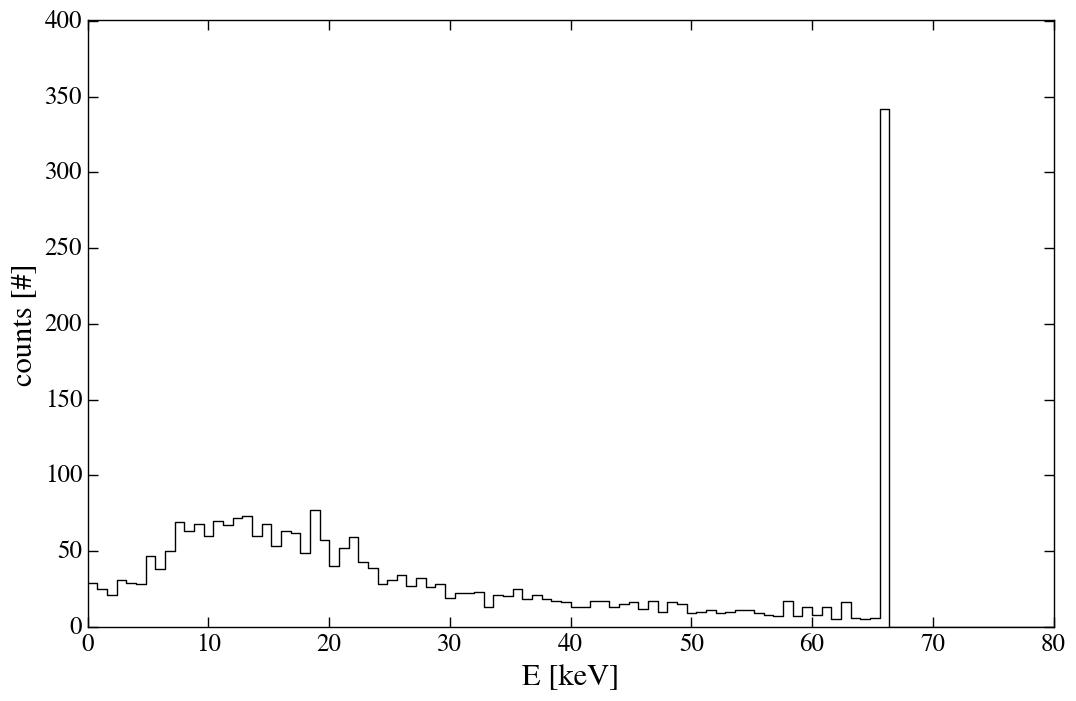

In [95]:
name = MC_name+"_H1D_etot_Z"
Cut = TPC_Cut
xBins = [100, 0, 80]

# genereated photons
plot_name = name+"_etot"
ROOT.gDirectory.Delete(plot_name)
H1D_etot = Hist(xBins[0], xBins[1], xBins[2], name=plot_name)
dTC_MC.Draw('etot/10.' + ' >> ' + plot_name, Cut, 'hist goff')

fig = plt.figure()
rplt.hist(H1D_etot)

plt.ylabel("counts [#]")
plt.xlabel("E [keV]")

plt.legend()
plt.plot()

plt.show()

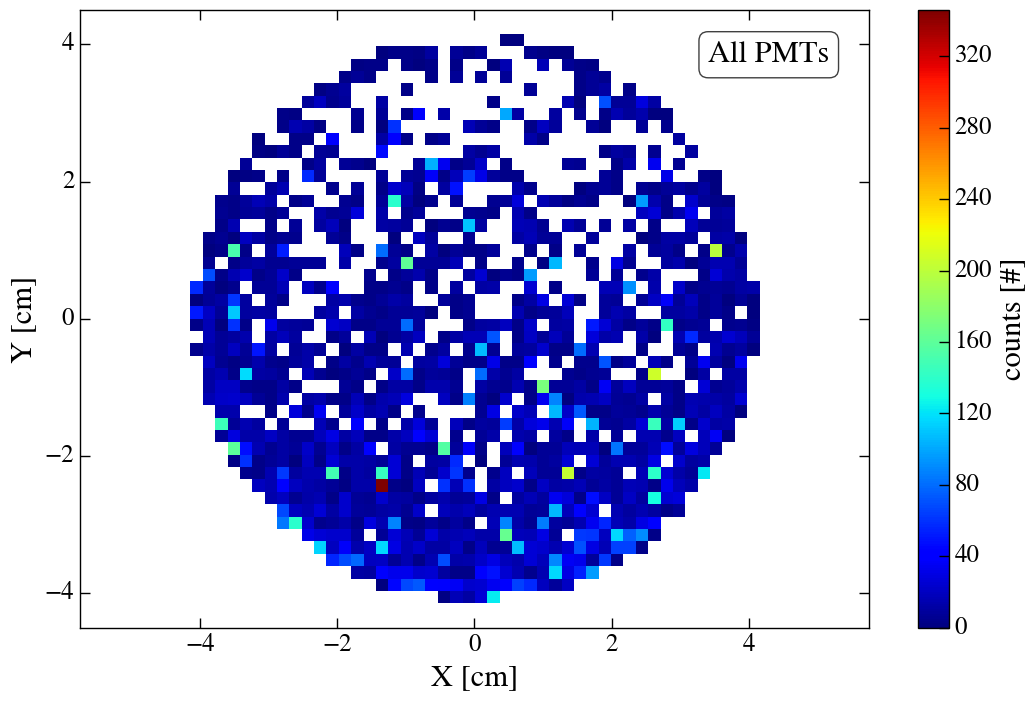

In [101]:
# Plot 2D LCE XY
name = MC_name+"_H2D_XY"
Cut = "zp/10.<={0} && zp/10.>={1} && (xp*xp + yp*yp)/10./10.>={2} && (xp*xp + yp*yp)/10./10.<={3}".format(LXe_maxZ,LXe_minZ,LXe_minRR,LXe_maxRR)
xBins = [50, LXe_minR-0.5, LXe_maxR+0.5]
yBins = [50, LXe_minR-0.5, LXe_maxR+0.5]

# genereated photons
plot_name = name+"_det"
ROOT.gDirectory.Delete(plot_name)
H2D_det = Hist2D(xBins[0], xBins[1], xBins[2], yBins[0], yBins[1], yBins[2], name=plot_name)
dTC_MC.Draw('yp/10. : xp/10.' + ' >> ' + plot_name, Cut, 'goff')

fig = plt.figure()
H2D = H2D_det
counts, xedges, yedges, im = rplt.hist2d(H2D,vmin=0.000000001)
plt.colorbar(im, label="counts [#]")

axes = plt.gca()
axes.text(0.95, 0.95, "All PMTs", transform=axes.transAxes, horizontalalignment='right',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

plt.xlabel("X [cm]")
plt.ylabel("Y [cm]")

plt.axis('equal')
plt.plot()

plt.show()